# Training

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chemprop/chemprop/blob/main/examples/training.ipynb)

In [1]:
# Install chemprop from GitHub if running in Google Colab
import os

if os.getenv("COLAB_RELEASE_TAG"):
    try:
        import chemprop
    except ImportError:
        !git clone https://github.com/chemprop/chemprop.git
        %cd chemprop
        !pip install .
        %cd examples

Cloning into 'chemprop'...
remote: Enumerating objects: 25517, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 25517 (delta 302), reused 171 (delta 158), pack-reused 25099 (from 3)
Receiving objects: 100% (25517/25517), 891.74 MiB | 19.95 MiB/s, done.
Resolving deltas: 100% (18274/18274), done.
/content/chemprop
Processing /content/chemprop
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/

# Import packages

In [2]:
from pathlib import Path

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
import pandas as pd

from chemprop import data, featurizers, models, nn

# Change data inputs here

In [3]:
chemprop_dir = Path.cwd().parent
input_path = chemprop_dir / "tests" / "data" / "regression" / "mol" / "mol.csv" # path to your data .csv file
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'smiles' # name of the column containing SMILES strings
target_columns = ['lipo'] # list of names of the columns containing targets

## Load data

In [4]:
df_input = pd.read_csv(input_path)
df_input

,smiles,lipo
0,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10
...,...,...
95,CC(C)N(CCCNC(=O)Nc1ccc(cc1)C(C)(C)C)C[C@H]2O[C...,2.20
96,CCN(CC)CCCCNc1ncc2CN(C(=O)N(Cc3cccc(NC(=O)C=C)...,2.04
97,CCSc1c(Cc2ccccc2C(F)(F)F)sc3N(CC(C)C)C(=O)N(C)...,4.49
98,COc1ccc(Cc2c(N)n[nH]c2N)cc1,0.20


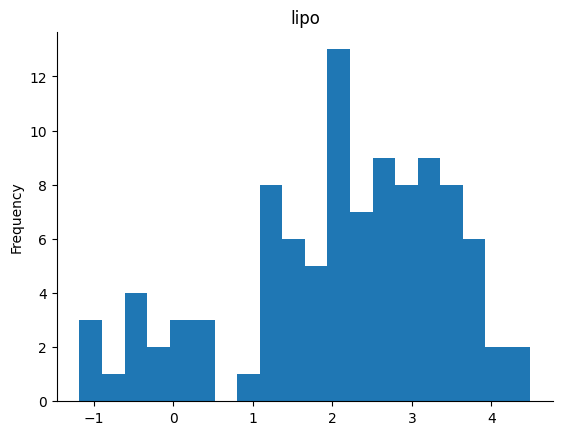

In [5]:
# @title lipo

from matplotlib import pyplot as plt
df_input['lipo'].plot(kind='hist', bins=20, title='lipo')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Get SMILES and targets

In [7]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

In [9]:
smis[:5] # show first 5 SMILES strings

array(['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14',
       'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23',
       'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl',
       'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3',
       'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1'],
      dtype=object)

In [8]:
ys[:5] # show first 5 targets

array([[ 3.54],
       [-1.18],
       [ 3.69],
       [ 3.37],
       [ 3.1 ]])

## Get molecule datapoints

In [10]:
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]

## Perform data splitting for training, validation, and testing

In [11]:
# available split types
list(data.SplitType.keys())

['SCAFFOLD_BALANCED',
 'RANDOM_WITH_REPEATED_SMILES',
 'RANDOM',
 'KENNARD_STONE',
 'KMEANS']

ChemProp's `make_split_indices` function will always return a two- (if no validation) or three-length tuple.
Each member is a list of length `num_replicates`.
The inner lists then contain the actual indices for splitting.

The type signature for this return type is `tuple[list[list[int]], ...]`.

In [12]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

ChemProp's splitting function implements our preferred method of data splitting, which is random replication.
It's also possible to add your own custom cross-validation splitter, such as one of those as implemented in scikit-learn, as long as you get the data into the same `tuple[list[list[int]], ...]` data format with something like this:

In [ ]:
from sklearn.model_selection import KFold

k_splits = KFold(n_splits=5)
k_train_indices, k_val_indices, k_test_indices = [], [], []
for fold in k_splits.split(mols):
    k_train_indices.append(fold[0])
    k_val_indices.append([])
    k_test_indices.append(fold[1])
k_train_data, _, k_test_data = data.split_data_by_indices(
    all_data, k_train_indices, None, k_test_indices
)

## Get MoleculeDataset
Recall that the data is in a list equal in length to the number of replicates, so we select the zero index of the list to get the first replicate.

In [ ]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.MoleculeDataset(train_data[0], featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.MoleculeDataset(val_data[0], featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.MoleculeDataset(test_data[0], featurizer)

## Get DataLoader

In [ ]:
train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)

# Change Message-Passing Neural Network (MPNN) inputs here

## Message Passing
A `Message passing` constructs molecular graphs using message passing to learn node-level hidden representations.

Options are `mp = nn.BondMessagePassing()` or `mp = nn.AtomMessagePassing()`

In [ ]:
mp = nn.BondMessagePassing()

## Aggregation
An `Aggregation` is responsible for constructing a graph-level representation from the set of node-level representations after message passing.

Available options can be found in ` nn.agg.AggregationRegistry`, including
- `agg = nn.MeanAggregation()`
- `agg = nn.SumAggregation()`
- `agg = nn.NormAggregation()`

In [ ]:
print(nn.agg.AggregationRegistry)

ClassRegistry {
    'mean': <class 'chemprop.nn.agg.MeanAggregation'>,
    'sum': <class 'chemprop.nn.agg.SumAggregation'>,
    'norm': <class 'chemprop.nn.agg.NormAggregation'>
}


In [ ]:
agg = nn.MeanAggregation()

## Feed-Forward Network (FFN)

A `FFN` takes the aggregated representations and make target predictions.

Available options can be found in `nn.PredictorRegistry`.

For regression:
- `ffn = nn.RegressionFFN()`
- `ffn = nn.MveFFN()`
- `ffn = nn.EvidentialFFN()`

For classification:
- `ffn = nn.BinaryClassificationFFN()`
- `ffn = nn.BinaryDirichletFFN()`
- `ffn = nn.MulticlassClassificationFFN()`
- `ffn = nn.MulticlassDirichletFFN()`

For spectral:
- `ffn = nn.SpectralFFN()` # will be available in future version

In [ ]:
print(nn.PredictorRegistry)

ClassRegistry {
    'regression': <class 'chemprop.nn.predictors.RegressionFFN'>,
    'regression-mve': <class 'chemprop.nn.predictors.MveFFN'>,
    'regression-evidential': <class 'chemprop.nn.predictors.EvidentialFFN'>,
    'regression-quantile': <class 'chemprop.nn.predictors.QuantileFFN'>,
    'classification': <class 'chemprop.nn.predictors.BinaryClassificationFFN'>,
    'classification-dirichlet': <class 'chemprop.nn.predictors.BinaryDirichletFFN'>,
    'multiclass': <class 'chemprop.nn.predictors.MulticlassClassificationFFN'>,
    'multiclass-dirichlet': <class 'chemprop.nn.predictors.MulticlassDirichletFFN'>,
    'spectral': <class 'chemprop.nn.predictors.SpectralFFN'>
}


In [ ]:
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

In [ ]:
ffn = nn.RegressionFFN(output_transform=output_transform)

## Batch Norm
A `Batch Norm` normalizes the outputs of the aggregation by re-centering and re-scaling.

Whether to use batch norm

In [ ]:
batch_norm = True

## Metrics
`Metrics` are the ways to evaluate the performance of model predictions.

Available options can be found in `metrics.MetricRegistry`, including

In [ ]:
print(nn.metrics.MetricRegistry)

ClassRegistry {
    'mse': <class 'chemprop.nn.metrics.MSE'>,
    'mae': <class 'chemprop.nn.metrics.MAE'>,
    'rmse': <class 'chemprop.nn.metrics.RMSE'>,
    'bounded-mse': <class 'chemprop.nn.metrics.BoundedMSE'>,
    'bounded-mae': <class 'chemprop.nn.metrics.BoundedMAE'>,
    'bounded-rmse': <class 'chemprop.nn.metrics.BoundedRMSE'>,
    'r2': <class 'chemprop.nn.metrics.R2Score'>,
    'binary-mcc': <class 'chemprop.nn.metrics.BinaryMCCMetric'>,
    'multiclass-mcc': <class 'chemprop.nn.metrics.MulticlassMCCMetric'>,
    'roc': <class 'chemprop.nn.metrics.BinaryAUROC'>,
    'prc': <class 'chemprop.nn.metrics.BinaryAUPRC'>,
    'accuracy': <class 'chemprop.nn.metrics.BinaryAccuracy'>,
    'f1': <class 'chemprop.nn.metrics.BinaryF1Score'>
}


In [ ]:
metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()] # Only the first metric is used for training and early stopping

## Constructs MPNN

In [ ]:
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): RMSE(task_weights=[[1.0]])
    (1): MAE(task_weigh

# Set up trainer

In [ ]:
# Configure model checkpointing
checkpointing = ModelCheckpoint(
    "checkpoints",  # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
    "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
    mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True,  # Always save the most recent checkpoint, even if it's not the best
)


trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=20, # number of epochs to train for
    callbacks=[checkpointing], # Use the configured checkpoint callback
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Start training

In [ ]:
trainer.fit(mpnn, train_loader, val_loader)

/home/knathan/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/knathan/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/home/knathan/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 90.6 K | train
4 | X_d_transform   | Identity         

/home/knathan/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, train_loss_step=0.880, val_loss=0.886, train_loss_epoch=1.010]        

Epoch 19: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s, train_loss_step=0.0757, val_loss=0.789, train_loss_epoch=0.066] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 2/2 [00:00<00:00,  3.75it/s, train_loss_step=0.0757, val_loss=0.789, train_loss_epoch=0.066]


# Test results

In [ ]:
results = trainer.test(dataloaders=test_loader)

/home/knathan/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/knathan/chemprop/examples/checkpoints/best-epoch=16-val_loss=0.78.ckpt
Loaded model weights from the checkpoint at /home/knathan/chemprop/examples/checkpoints/best-epoch=16-val_loss=0.78.ckpt
/home/knathan/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mae          │     0.643399715423584     │
│         test/rmse         │    0.9120855927467346     │
└───────────────────────────┴───────────────────────────┘